<a href="https://colab.research.google.com/github/ankita9084/Blood-cancer/blob/main/C_NMC_Leukemia_using_ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
import skimage.io
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Instantiating the model for loading the weights and biases and preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

%matplotlib inline

In [7]:
train_dataset_0_all = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [8]:
valid_data    = pd.read_csv('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [9]:
A = []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

A = np.array(A)
H = np.array(H)

len(A),len(H)

(7281, 3389)

In [10]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

100%|██████████| 3389/3389 [48:47<00:00,  1.16it/s]


((10670, 128, 128, 3), (10670,))

In [11]:
Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 254.15it/s]


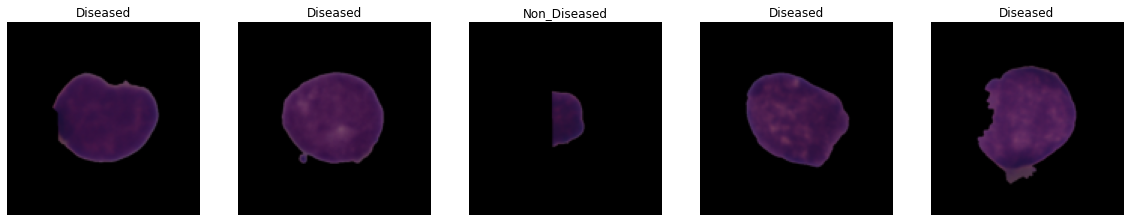

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [13]:
X = Image
y = Label

In [14]:
del Image
del Label
del A
del H

In [15]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [16]:
X_val = []

for image_name in valid_data.new_names:
    # Loading images
    img = imread('/content/drive/MyDrive/Programs/Datasets/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (128,128))
    # Appending them into list
    X_val.append(img)
 
# Converting into array
X_val = np.array(X_val)

# Storing target values as well 
y_val = valid_data.labels.values

In [17]:
train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2,
                                    preprocessing_function=preprocess_input)
train_datagen.fit(X)

In [18]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen.fit(X_val)

In [20]:
res152 = tensorflow.keras.applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=(128,128,3))

234561536/234545216 [==============================] - 9s 0us/step


In [21]:
res152.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [22]:
for layers in res152.layers:
    layers.trainable = False

In [23]:
x = Flatten()(res152.output)

In [24]:
fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

In [25]:
model = Model(inputs = res152.input, outputs = final_layer)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [27]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [28]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)


callback_list = [earlystopping, checkpoint, learning_rate]

In [29]:
model_history = model.fit(train_datagen.flow(X, y, batch_size=512), 
                          validation_data = (X_val, y_val),
                          epochs = 500,
                          verbose = 1,
                          callbacks = callback_list)

Epoch 1/500
21/21 [==============================] - 123s 4s/step - loss: 0.6961 - accuracy: 0.6556 - val_loss: 1.3660 - val_accuracy: 0.6529

Epoch 00001: val_accuracy improved from -inf to 0.65292, saving model to ./best_weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/500
21/21 [==============================] - 71s 3s/step - loss: 0.5283 - accuracy: 0.7539 - val_loss: 1.9277 - val_accuracy: 0.6529

Epoch 00002: val_accuracy did not improve from 0.65292
Epoch 3/500
21/21 [==============================] - 71s 3s/step - loss: 0.5082 - accuracy: 0.7660 - val_loss: 1.8047 - val_accuracy: 0.6529

Epoch 00003: val_accuracy did not improve from 0.65292
Epoch 4/500
21/21 [==============================] - 70s 3s/step - loss: 0.4976 - accuracy: 0.7729 - val_loss: 1.9728 - val_accuracy: 0.6529

Epoch 00004: val_accuracy did not improve from 0.65292
Epoch 5/500
21/21 [==============================] - 71s 3s/step - loss: 0.4937 - accuracy: 0.7813 - val_loss: 1.6072 - val_accuracy: 0.6529

Epoch 00005: val_accuracy did not improve from 0.65292
Epoch 6/500
21/21 [==============================] - 70s 3s/step - loss: 0.4969 - accuracy: 0.7748 - val_loss: 1.8060 - val_accuracy: 0.6529

Epoch 00006: val_accuracy did not improve from 0.65292
Epoch 7/500
21/